http://imagesci.ece.cmu.edu/files/paper/2019/PhaseCam_ICCP19.pdf

#Imports

In [1]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
# import random
# import glob
# import os

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
# import torchsummary as summary
from torch.optim import lr_scheduler
from torch.autograd import Variable
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/nfs4/mikhilg/miniconda3/envs/rnd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


#DATA

In [4]:
# from scipy.io import loadmat
import h5py

files = h5py.File('../nyu_depth_v2_labeled.mat.1','r')

In [5]:
# plt.show()
# plt.imshow(files['depths'][1].transpose((1,0)))
print(files['images'][0].shape)
# print(files['images'][0].shape[0])
np.min(files['depths'][1])

(3, 640, 480)


1.1237347

#DATALOADER Class

In [7]:
class ImDataNYU(Dataset):
    def calculate_mean(self, images):
        mean_image = np.mean(images, axis=0)
        return mean_image

    def __init__(self, filename, Mode, rgb_transform = None, depth_transform = None):
        f = h5py.File(filename, 'r')
        images_data = f['images'][0:1449]
        depths_data = f['depths'][0:1449]

        if Mode == "training":
            self.images = images_data[0:1150]
            self.depths = depths_data[0:1150]
        elif Mode == "validation":
            self.images = images_data[1150:1350]
            self.depths = depths_data[1150:1350]

        elif Mode == "test":
            self.images = images_data[1350:]
            self.depths = depths_data[1350:]

        self.rgb_transform = rgb_transform
        self.depth_transform = depth_transform
        self.mean_image = self.calculate_mean(images_data[0:1449])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # image = (image - self.mean_image)/np.std(image)
        image = image.transpose((2, 1, 0)) #Verticslly jacked image
        #image = Image.fromarray(image)
        if self.rgb_transform:
            image = self.rgb_transform(image)

        depth = self.depths[idx]
        #depth = np.reshape(depth, (1, depth.shape[0], depth.shape[1]))
        depth = depth.transpose((1, 0)) #Verticslly jacked depth
        if self.depth_transform:
            depth = self.depth_transform(depth)
        #sample = {'image': image, 'depth': depth}
        return image,depth


#Augmengt the data 

In [8]:
#Original DATA
dataset_location='nyu_depth_v2_labeled.mat.1'
batch_size=4
IMAGE_HEIGHT, IMAGE_WIDTH = 400,400
rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

og_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = rgb_transforms, depth_transform = depth_transforms)
# train_loader = torch.utils.data.DataLoader(og_data,batch_size = batch_size, shuffle = True)

In [9]:
#Vertical_Flip data

Vflip_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.RandomVerticalFlip(p=1.0),
                                         transforms.ToTensor()
                                         ])
Vflip_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.RandomVerticalFlip(p=1.0),
                                           transforms.ToTensor()
                                           ])

Vflip_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = Vflip_rgb_transforms, depth_transform = Vflip_depth_transforms)

In [10]:
# #Horizontal_Flip data

# gauss_rgb_transforms = transforms.Compose([ 
#                                          transforms.ToPILImage(),
#                                          transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
# #                                          transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#                                          transforms.ToTensor()
#                                          ])
# g_depth_transforms = transforms.Compose([
#                                            transforms.ToPILImage(),
#                                            transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
# #                                            transforms.RandomHorizontalFlip(p=1.0),
#                                            transforms.ToTensor()
#                                            ])

# gauss_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = gauss_rgb_transforms, depth_transform = g_depth_transforms)

In [11]:
#rotn data
rot_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.RandomRotation(degrees=(45)),
                                         transforms.ToTensor()
                                         ])
rot_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.RandomRotation(degrees=(45)),
                                           transforms.ToTensor()
                                           ])

rot_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = rot_rgb_transforms, depth_transform = rot_depth_transforms)

#Data Loader

In [12]:
#CenterCrop(size=256)
crop_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
                                         transforms.CenterCrop(size=256),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
crop_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.CenterCrop(size=256),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

crop_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = crop_rgb_transforms, depth_transform = crop_depth_transforms)

In [13]:
# RandomEqualize(p=0.5)
#CenterCrop(size=256)
eq_rgb_transforms = transforms.Compose([ 
                                         transforms.ToPILImage(),
#                                          transforms.RandomEqualize(p=1.0),
                                         transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                         transforms.ToTensor()
                                         ])
eq_depth_transforms = transforms.Compose([
                                           transforms.ToPILImage(),
                                           transforms.CenterCrop(size=256),
                                           transforms.Resize((IMAGE_WIDTH,IMAGE_HEIGHT)),
                                           transforms.ToTensor()
                                           ])

eq_data = ImDataNYU( dataset_location,Mode='training', rgb_transform = crop_rgb_transforms, depth_transform = crop_depth_transforms)

In [14]:
#Total data
# total_data = torch.utils.data.ConcatDataset([og_data, rot_data ,gauss_data ])
total_data = torch.utils.data.ConcatDataset([og_data,rot_data,crop_data ,Vflip_data]) #Vflip_data , Hflip_data
#total_data = torch.utils.data.ConcatDataset([og_data,Vflip_data])    #rot_data, ,Hflip_data
train_loader = torch.utils.data.DataLoader(total_data,batch_size = batch_size, shuffle = True)

In [15]:
#crop_data ,rcr_data #Validation set
validation_data = ImDataNYU( dataset_location,Mode='validation', rgb_transform = rgb_transforms, depth_transform = depth_transforms)
val_loader = torch.utils.data.DataLoader(validation_data,batch_size = batch_size, shuffle = False)

#model

In [16]:
class DoubleConv(nn.Module):
  def __init__(self,in_chan,out_chan):
    super(DoubleConv,self).__init__()
    self.conv  =  nn.Sequential(
        nn.Conv2d(in_chan,out_chan,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_chan),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_chan,out_chan,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_chan),
        nn.ReLU(inplace=True)
    )
  def forward(self,x):
    x = self.conv(x)
    return x
    
class attention(nn.Module):
    """
    Attention in UNet: 
    """
    def __init__(self,prev_ch,skip_ch,op_ch):
        super(attention, self).__init__()
        
        self.gate_weight = nn.Sequential(
            nn.Conv2d(prev_ch,op_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(op_ch)
            )
        self.skip_weight = nn.Sequential(
            nn.Conv2d(skip_ch,op_ch, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(op_ch)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(op_ch, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    pass
    def forward(self, gate, skip_connection):
        g1 = self.gate_weight(gate)
#         print("g1",type(g1))
        x1 = self.skip_weight(skip_connection)
#         print("x1",type(x1))
        psi = self.relu(g1 + x1)
#         print("psi1",psi.shape)
        psi1 = self.psi(psi)
        
        out = skip_connection * psi1
        return out

class UNetDepth_attention(nn.Module):
  def __init__(self,feature = 8*[32,64,128,256,512]):
    super(UNetDepth_attention,self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.enc1 = DoubleConv(3,feature[0])
    self.enc2 = DoubleConv(feature[0],feature[1])
    self.enc3 = DoubleConv(feature[1],feature[2])
    self.enc4 = DoubleConv(feature[2],feature[3])
    self.enc5 = DoubleConv(feature[3],feature[4])
    
    self.upsample1 = nn.ConvTranspose2d(in_channels=feature[4],out_channels=feature[3],kernel_size=2,stride=2)
    self.att1 = attention(prev_ch=feature[3],skip_ch=feature[3],op_ch=feature[2])
    self.dec1 = DoubleConv(feature[4],feature[3])
    
    self.upsample2 = nn.ConvTranspose2d(in_channels=feature[3],out_channels=feature[2],kernel_size=2,stride=2)
    self.att2 = attention(prev_ch=feature[2],skip_ch=feature[2],op_ch=feature[1])
    self.dec2 = DoubleConv(feature[3],feature[2])
    
    self.upsample3 = nn.ConvTranspose2d(in_channels=feature[2],out_channels=feature[1],kernel_size=2,stride=2)
    self.att3 = attention(prev_ch=feature[1],skip_ch=feature[1],op_ch=feature[0])
    self.dec3 = DoubleConv(feature[2],feature[1])
    
    self.upsample4 = nn.ConvTranspose2d(in_channels=feature[1],out_channels=feature[0],kernel_size=2,stride=2)
    self.att4 = attention(prev_ch=feature[0],skip_ch=feature[0],op_ch=feature[0]//2)
    self.dec4 = DoubleConv(feature[1],feature[0])
    
    self.out  = nn.Conv2d(feature[0],1,kernel_size=1)
    self.drop = nn.Dropout2d(p=0.3)

  def forward(self,x):
    #encoder
                          #inchannel 3 in_image = 256 256
    x1  = self.enc1(x)    #inchannel=3 outchannel=32
    x1  = self.drop(x1)
    x2  = self.pool(x1)   # 32 128 128
    x2  = self.drop(x2)   ##########$################
    x3  = self.enc2(x2)   # inchannel=32 outchannel=64
    x4  = self.pool(x3)   # 64 64 64 
    x4  = self.drop(x4)   #######################
    x5  = self.enc3(x4)   # inchannel=64 outchannel=128
    x6  = self.pool(x5)   #128 32 32
    x7  = self.enc4(x6)   #inchannel=128 outchannel=256
    x8  = self.pool(x7)   #256 16 16
    x9  = self.enc5(x8)   #inchannel=256 outchannel=512
#     print("x9",x9.shape)
    #decoder
    
    x10 = self.upsample1(x9)
    a10 = self.att1(gate=x10,skip_connection=x7)
#     print("a10",a10.shape)
    au10 = torch.cat([a10,x10],dim=1)
    d10 = self.dec1(au10)
    
    
    x11 = self.upsample2(d10)
    a11 = self.att2(gate=x11,skip_connection=x5)
    au11 = torch.cat([a11,x11],dim=1)
    d11 = self.dec2(au11)
    
    x12 = self.upsample3(d11)
    a12 = self.att3(gate=x12,skip_connection=x3)
    au12 = torch.cat([a12,x12],dim=1)
    d12 = self.dec3(au12)
    
    x13 = self.upsample4(x12)
    a13 = self.att4(gate=x13,skip_connection=x1)
    au13 = torch.cat([a13,x13],dim=1)
    d13 = self.dec4(au13)
    
#     #print("x11", x11.shape)
#     x12 = torch.cat([self.upsample2(x11),x5],dim=1)
#     #print("x12", x12.shape)
#     x13 = self.dec2(x12)
# #     x13 = self.drop(x13)  ###############
#     #print("x13", x13.shape)
#     x14 = torch.cat([self.upsample3(x13),x3],dim=1)
#     x15 = self.dec3(x14)
#     #print("x15", x15.shape)
#     x16 = torch.cat([self.upsample4(x15),x1],dim=1)
# #     x16 = self.drop(x16)   ################
#     x17 = self.dec4(x16)
    #print("x17", x17.shape)
    out = self.out(d13)
    #print("out", out.shape)
    return out

net = UNetDepth_attention().to(device)
model = torch.nn.DataParallel(net, device_ids=[0, 1, 2, 3])

In [17]:
from torchsummary import summary
summary(model,(3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
├─UNetDepth_attention: 1-1               []                        --
├─UNetDepth_attention: 1                 []                        --
|    └─DoubleConv: 2-1                   []                        --
|    └─DoubleConv: 2                     []                        --
|    |    └─Sequential: 3-1              []                        10,272
├─UNetDepth_attention: 1-2               [-1, 1, 256, 256]         --
├─UNetDepth_attention: 1                 []                        --
|    └─DoubleConv: 2-2                   [-1, 32, 256, 256]        --
|    └─DoubleConv: 2                     []                        --
|    |    └─Sequential: 3-2              [-1, 32, 256, 256]        --
|    └─Dropout2d: 2-3                    [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
|    └─Dropout2d: 2-5                    [-1, 32, 128, 128]        --
|    └─Doub

Layer (type:depth-idx)                   Output Shape              Param #
├─UNetDepth_attention: 1-1               []                        --
├─UNetDepth_attention: 1                 []                        --
|    └─DoubleConv: 2-1                   []                        --
|    └─DoubleConv: 2                     []                        --
|    |    └─Sequential: 3-1              []                        10,272
├─UNetDepth_attention: 1-2               [-1, 1, 256, 256]         --
├─UNetDepth_attention: 1                 []                        --
|    └─DoubleConv: 2-2                   [-1, 32, 256, 256]        --
|    └─DoubleConv: 2                     []                        --
|    |    └─Sequential: 3-2              [-1, 32, 256, 256]        --
|    └─Dropout2d: 2-3                    [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 128, 128]        --
|    └─Dropout2d: 2-5                    [-1, 32, 128, 128]        --
|    └─Doub

#training

In [18]:
# def ScaleInvariantLoss(output, depth):
#     # di = output - target
#     output = torch.log(output+1)
#     target = torch.log(depth+1)
#     di = torch.abs(depth - output)
#     n = (IMAGE_HEIGHT*IMAGE_WIDTH)
#     di2 = torch.pow(di, 2)
#     fisrt_term = torch.sum(di2)/n
#     second_term = torch.pow(torch.sum(di), 2)/ (n**2)
#     loss = fisrt_term - second_term
#     return loss.mean()
def gradLoss(output, depth):
    # di = grad(output - target)
    di = torch.gradient(output-depth)
    n = IMAGE_HEIGHT*IMAGE_WIDTH
    fisrt_term = torch.sum(di[1])/np.sqrt(n)
    second_term = torch.sum(di[2])/ np.sqrt(n)
    loss = torch.abs(fisrt_term) + torch.abs(second_term)
    return loss


In [20]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
def log_no_explode(z):
    return torch.log(torch.clamp(z,1e-8,1e8))
class KLdivergence(nn.Module):
    def __init__(self):
        super(KLdivergence, self).__init__()
    def forward(self, Q,P):
        kl_loss = P * log_no_explode(P/Q)
        pixel_loss = torch.sum(kl_loss, dim=-1)
        total_loss = torch.mean(pixel_loss)
        return total_loss

class Att_loss(KLdivergence):
    def __init__(self,scale=1):
        super(Att_loss, self).__init__()
        self.scale = scale
    def get_similarity(self,depth):
        b, _, h, w = depth.shape
        M = depth.reshape((b, h * w, 1))
        N = depth.reshape((b, 1, h * w))
        W = F.softmax(-torch.abs(torch.log(M) - torch.log(N)), -1)
        W[torch.isnan(W)] = 0
        return W
    def get_gt_sim_map(self, label):
        b, _, h, w = label.shape
        res_label = F.interpolate(label, size=(h//8//self.scale, w//8//self.scale), mode='nearest')
        gt_sim_map = self.get_similarity(res_label)
        return gt_sim_map
    def forward(self, sim_map, label):
        """
        Parameters
        ----------
        sim_map: [batch_size, n, n]
        label: [batch_size, 1, h, w]
        """
        gt_sim_map = self.get_gt_sim_map(label)
        return super(AttentionLoss2d, self).forward(sim_map, gt_sim_map)
class _BaseEntropyLoss2d(nn.Module):
    def __init__(self, ignore_index=None, reduction='sum', use_weights=False, weight=None):
        """
        Parameters
        ----------
        ignore_index : Specifies a target value that is ignored
                       and does not contribute to the input gradient
        reduction : Specifies the reduction to apply to the output: 
                    'mean' | 'sum'. 'mean': elemenwise mean, 
                    'sum': class dim will be summed and batch dim will be averaged.
        use_weight : whether to use weights of classes.
        weight : Tensor, optional
                a manual rescaling weight given to each class.
                If given, has to be a Tensor of size "nclasses"
        """
        super(_BaseEntropyLoss2d, self).__init__()
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.use_weights = use_weights
        if use_weights:
            print("w/ class balance")
            print(weight)
            self.weight = torch.FloatTensor(weight).cuda()
        else:
            print("w/o class balance")
            self.weight = None

    def get_entropy(self, pred, label):
        """
        Return
        ------
        entropy : shape [batch_size, h, w, c]
        Description
        -----------
        Information Entropy based loss need to get the entropy according to your implementation, 
        each element denotes the loss of a certain position and class.
        """
        raise NotImplementedError

    def forward(self, pred, label):
        """
        Parameters
        ----------
        pred: [batch_size, num_classes, h, w]
        label: [batch_size, h, w]
        """
        assert not label.requires_grad
        assert pred.dim() == 4
        assert label.dim() == 3
        assert pred.size(0) == label.size(0), "{0} vs {1} ".format(pred.size(0), label.size(0))
        assert pred.size(2) == label.size(1), "{0} vs {1} ".format(pred.size(2), label.size(1))
        assert pred.size(3) == label.size(2), "{0} vs {1} ".format(pred.size(3), label.size(3))

        n, c, h, w = pred.size()
        if self.use_weights:
            if self.weight is None:
                print('label size {}'.format(label.shape))
                freq = np.zeros(c)
                for k in range(c):
                    mask = (label[:, :, :] == k)
                    freq[k] = torch.sum(mask)
                    print('{}th frequency {}'.format(k, freq[k]))
                weight = freq / np.sum(freq) * c
                weight = np.median(weight) / weight
                self.weight = torch.FloatTensor(weight).cuda()
                print('Online class weight: {}'.format(self.weight))
        else:
            self.weight = 1
        if self.ignore_index is None:
            self.ignore_index = c + 1

        entropy = self.get_entropy(pred, label)

        mask = label != self.ignore_index
        weighted_entropy = entropy * self.weight

        if self.reduction == 'sum':
            loss = torch.sum(weighted_entropy, -1)[mask].mean()
        elif self.reduction == 'mean':
            loss = torch.mean(weighted_entropy, -1)[mask].mean()
        return loss


class OrdinalRegression2d(_BaseEntropyLoss2d):
    def __init__(self, ignore_index=None, reduction='sum', use_weights=False, weight=None):
        super(OrdinalRegression2d, self).__init__(ignore_index, reduction, use_weights, weight)

    def get_entropy(self, pred, label):
        n, c, h, w = pred.size()
        label = label.unsqueeze(3).long()
        pred = pred.permute(0, 2, 3, 1)
        mask10 = ((torch.arange(c)).cuda() <  label).float()
        mask01 = ((torch.arange(c)).cuda() >= label).float()
        entropy = safe_log(pred) * mask10 + safe_log(1 - pred) * mask01
        return -entropy


In [22]:
#Parameters
epochs=15
LEARNING_RATE = 1e-3
MOMENTUM  = 1e-4
WEIGHT_DECAY = 1e-4
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM ,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

# loss_f = nn.MSELoss()
loss_f = nn.KLDivLoss()
training_loss=[]
validation_loss=[]
for epoch in range(epochs):
  loop = tqdm(enumerate(train_loader), total = len(train_loader),desc = f'Epoch [{epoch+1}/{epochs}]')
  running_loss=0
  for batch_idx, (image,depth) in loop:
    image=image.to(device)
    depth=depth.to(device)
    optimizer.zero_grad()
    output= model(image)
    loss = loss_f(output,depth) #+ (gradLoss(output,depth))
    loss.backward()
    optimizer.step()
    running_loss+=loss
  running_loss/=(len(train_loader))
  training_loss.append(running_loss)
  print (f'Epoch [{epoch+1}/{epochs}], TrainLoss: {running_loss:.4f}',end='')

  with torch.no_grad():
    running_val_loss=0
    for val_image,val_depth in val_loader:
      val_image=val_image.to(device)
      val_depth=val_depth.to(device)
      val_out = model(val_image)
      val_loss = loss_f(val_out,val_depth) #+ (gradLoss(output,depth))
      running_val_loss +=val_loss
    running_val_loss/=(len(val_loader))
    validation_loss.append(running_val_loss)
    print(f'\tValLoss_: {running_val_loss: .4f}')
PATH = './UNetDepth3drop.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/15]:   0%|                                                                                                                                                                | 0/1150 [00:00<?, ?it/s]/nfs4/sachinp/miniconda3/envs/unet/lib/python3.9/site-packages/torch/nn/functional.py:2741: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Epoch [1/15]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1150/1150 [02:03<00:00,  9.28it/s]


Epoch [1/15], TrainLoss: -113.7576	ValLoss_: -395.6293


Epoch [2/15]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1150/1150 [02:05<00:00,  9.15it/s]


Epoch [2/15], TrainLoss: -727.7004	ValLoss_: -1406.2272


Epoch [3/15]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1150/1150 [02:05<00:00,  9.13it/s]


Epoch [3/15], TrainLoss: -1790.4441	ValLoss_: -2872.7471


Epoch [4/15]:  31%|██████████████████████████████████████████████▎                                                                                                       | 355/1150 [00:38<01:26,  9.23it/s]


KeyboardInterrupt: 

In [23]:
PATH = './UNetDepth3drop.pth'
torch.save(model.state_dict(), PATH)

In [24]:
PATH = './UNetDepth3drop.pth'
ff = UNetDepth_attention().to(device)
check = torch.nn.DataParallel(ff, device_ids=[0, 1, 2, 3])
check.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([3, 400, 400])


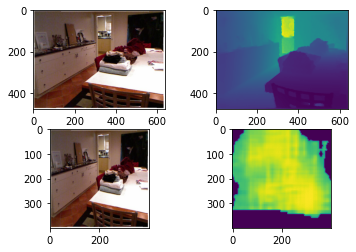

In [25]:
f, axarr = plt.subplots(2,2)
image_test =  files['images'][1440]
depth_test =  files['depths'][1440]
axarr[0,0].imshow(image_test.T)
axarr[0,1].imshow(depth_test.T)
# img=rgb_transforms(image_test.T)
img=rgb_transforms(image_test.T)
# dep=depth_transforms(Image.fromarray(np.uint8(depth_test.T)))
dep=depth_transforms(depth_test.T)
print(img.shape)
img2=img.view(1, 3, IMAGE_HEIGHT,IMAGE_WIDTH)
test_out = check(img2.to(device))
axarr[1,1].imshow(test_out[0][0].detach().cpu().numpy(), interpolation="bilinear")
axarr[1,0].imshow(img.permute(1,2,0))

In [ ]:
# p = rcr_depth_transforms(files['depths'][1420].T)
# plt.imshow(np.transpose(p[0].detach().cpu().numpy(), (0,1)), interpolation="bilinear")

In [ ]:
l = torch.sqrt(loss_f(dep.to(device),test_out))
l

In [ ]:
plt.imshow(test_out[0][0].detach().cpu().numpy(), interpolation="bilinear")